In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from datasets import load_dataset
import pandas as pd

import torch
from torch import nn
from tqdm import tqdm

from data_processing import get_datafrom_tokenizer
from baseline import BERTClass

import pickle as pkl
import matplotlib.pyplot as plt

In [3]:
dataset = load_dataset("silicone", "dyda_da")

Found cached dataset silicone (C:/Users/jerem/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(dataset["train"])
df

,Utterance,Dialogue_Act,Dialogue_ID,Label,Idx
0,"say , jim , how about going for a few beers af...",directive,1,1,0
1,you know that is tempting but is really not go...,commissive,1,0,1
2,what do you mean ? it will help us to relax .,question,1,3,2
3,do you really think so ? i don't . it will jus...,question,1,3,3
4,i guess you are right.but what shall we do ? i...,question,1,3,4
...,...,...,...,...,...
87165,i want a pair of locus .,directive,11117,1,87165
87166,"take a look at the ones on display , please .",commissive,11117,0,87166
87167,i need size 41 .,directive,11117,1,87167
87168,"could i have the check , please ?",directive,11118,1,87168


In [34]:
small_train = pd.DataFrame(dataset["train"])[["Utterance", "Label"]].sample(10000, ignore_index=True)
small_test = pd.DataFrame(dataset["test"])[["Utterance", "Label"]].sample(1000, ignore_index=True)

In [22]:
simple_train = pd.DataFrame(dataset['train'])[["Utterance", "Label"]]
simple_test = pd.DataFrame(dataset['test'])[["Utterance", "Label"]]
simple_train

,Utterance,Label
0,"say , jim , how about going for a few beers af...",1
1,you know that is tempting but is really not go...,0
2,what do you mean ? it will help us to relax .,3
3,do you really think so ? i don't . it will jus...,3
4,i guess you are right.but what shall we do ? i...,3
...,...,...
87165,i want a pair of locus .,1
87166,"take a look at the ones on display , please .",0
87167,i need size 41 .,1
87168,"could i have the check , please ?",1


In [6]:
train_loader, test_loader = get_datafrom_tokenizer(simple_train, simple_test)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BERTClass()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [9]:
def compute_test_loss(model, testloader, criterion, no_training_phase=False):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader, 0):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * targets.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        if no_training_phase:
            print(f"Test Error: \n Accuracy: {(100*correct/total):>0.1f}%, Avg loss: {test_loss/total:>8f} \n")
            return None
        else:
            return test_loss/total, 1-correct/total

In [24]:
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 l3.weight
	 l3.bias


In [12]:
len(train_loader)

1363

In [51]:
def train(train_loader, test_loader, train_epoch=10):
    loss_train = []
    train_accuracy = []
    loss_test = []
    test_accuracy = []

    epoch_pbar = tqdm(total=train_epoch, leave=False)
    for epoch in range(train_epoch):  
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            pbar = tqdm(leave=True, total=len(train_loader))
            for i, data in enumerate(train_loader, 0):
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                targets = data['targets'].to(device)
                
                optimizer.zero_grad()

                outputs = model(ids, mask, token_type_ids)
                # outputs = probs.argmax(1) # to use for accuracy metrics
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)

                loss = criterion(outputs, targets)
                loss.backward()
            
                optimizer.step()
            
                train_loss += loss.item() * len(targets)
                pbar.set_description(f"Train Loss : {loss: .4f}")
                pbar.update()

            loss, errors = compute_test_loss(model, test_loader, criterion)
            loss_test.append(loss)
            test_accuracy.append(1-errors)
            pbar.set_description(f"Train Loss : {train_loss/total: .4f} | Test Loss : {loss: .4f} | Train Error : {1 - correct/total: .2%} | Test Error : {errors: .2%}")
            loss_train.append(train_loss/total)
            train_accuracy.append(correct/total)
            epoch_pbar.set_description(f"Epoch : {epoch}/{train_epoch} | Train Loss : {train_loss/total: .4f} | Test Loss : {loss: .4f} | Train Error : {1 - correct/total: .2%} | Test Error : {errors: .2%}")
            epoch_pbar.update() 
            
    return loss_test, test_accuracy, loss_train, train_accuracy

In [52]:
# torch.save(model.state_dict(), "../baseline_dict3.pt")

In [15]:
compute_test_loss(model, test_loader, criterion, no_training_phase=True)

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.705719 



In [53]:
train_loader, test_loader = get_datafrom_tokenizer(small_train, small_test)
loss_test, test_accuracy, loss_train, train_accuracy = train(train_loader, test_loader)

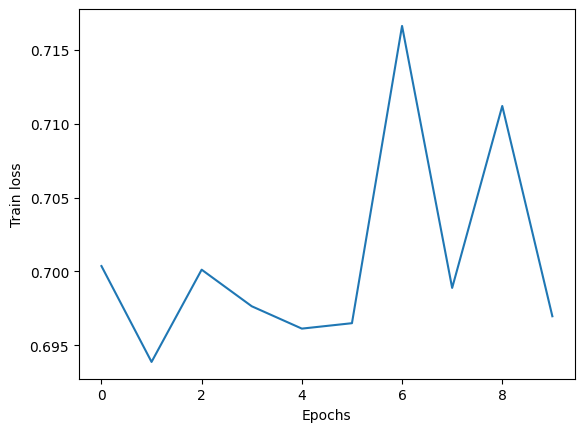

In [62]:
plt.plot(loss_test)
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()